In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Model, load_model
from keras.layers import Dense, Input, Dropout, GRU, Activation, Bidirectional, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import plot_model
#import sklearn
#from sklearn.metrics import accuracy_score, hamming_loss, jaccard_similarity_score

Using TensorFlow backend.


In [2]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [3]:
def sentence_to_word(sen):
    words = sen.lower().strip().split(' ')
    return words

In [4]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('./glove.6B/glove.6B.100d.txt')

In [5]:
ss = pd.read_csv('Eq_Lab5109.csv')
lab = ss['labels']
ss = ss.tweets.apply(str)

In [6]:
ss = np.array(ss)

In [7]:
def s2i(X, word_to_index, max_len):
    m = X.shape[0]                    
    X_indices = np.zeros((m, max_len))
    for i in range(m):                               
        sentence_words = X[i].lower().strip().split(' ')
        j = 0
        for w in sentence_words:
            if(w == ''):
                continue
            if w in word_to_index.keys():
                X_indices[i, j] = word_to_index[w]
            else:
                X_indices[i, j] = word_to_index['<unk>']
            j += 1
    return X_indices

In [8]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [9]:
def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [10]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [11]:
def embeddings(word_to_vec_map, word_to_index):
    voc_len = len(word_to_index)+1
    em_dim = word_to_vec_map['a'].shape[0]
    em_mat = np.zeros((voc_len, em_dim))
    for word, index in word_to_index.items():
        em_mat[index, :] = word_to_vec_map[word]
    embedding_layer = Embedding(voc_len, em_dim, weights=[em_mat],trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([em_mat])
    return embedding_layer

In [12]:
embedding_layer = embeddings(word_to_vec_map, word_to_index)

In [13]:
def biGRUPredictor(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    embedding_layer = embeddings(word_to_vec_map, word_to_index)
    embs = embedding_layer(sentence_indices)
    X = Bidirectional(GRU(10,return_sequences=True))(embs)
    X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(sentence_indices, X)
    return model

In [14]:
def biLSTMPredictor(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    embedding_layer = embeddings(word_to_vec_map, word_to_index)
    embs = embedding_layer(sentence_indices)
    X = Bidirectional(GRU(16,return_sequences=True))(embs)
    #X = keras.layers.LeakyReLU()(X)
    X = Dropout(0.75)(X)
    X = keras.layers.Conv1D(19, 3, padding='same',activation='elu')(X)
    X = Bidirectional(LSTM(32,return_sequences=True))(X)
    #X = keras.layers.LeakyReLU()(X)
    X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(sentence_indices, X)
    return model

In [15]:
K.clear_session()

In [16]:
model = biGRUPredictor((None, ), word_to_vec_map, word_to_index)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         40000200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 20)          6660      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 20)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           21        
Total params: 40,006,881
Trainable params: 6,681
Non-trainable params: 40,000,200
_________________________________________________________________


In [17]:
lstm_model = biLSTMPredictor((None, ), word_to_vec_map, word_to_index)
lstm_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 100)         40000200  
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 32)          11232     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 19)          1843      
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 64)          13312     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 64)          0   

In [18]:
i = 0
for w in lab:
    lab[i]=lab[i].strip()
    #print(i,': ',lab[i])
    for k in range(5):
        lab[i]=lab[i].replace('  ', ' ')
    i+=1

In [19]:
def label_to_ov(label, s):
    label = label.strip()
    labels = label.split(' ')
    if(label == '0'):
        ov = np.zeros((s, 1))
    else:
        ov = np.zeros((s, 1))
        for l in labels:
            ov[int(l)-1] = 1
    return ov

In [20]:
label_oh = []
for label in lab:
    #print(label)
    label_oh.append(label_to_ov(label, 60))

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [f1, precision, recall, 'accuracy'])

In [22]:
lstm_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = [f1, precision, recall, 'accuracy'])

In [23]:
X=s2i(ss, word_to_index, max_len=60)

In [24]:
Y = np.array(label_oh)

In [25]:
history = model.fit(X, Y,validation_split=0.20, epochs = 60)

Train on 4088 samples, validate on 1022 samples
Epoch 1/60
4088/4088 [==============================] - 18s 4ms/step - loss: 0.3297 - f1: nan - precision: 0.3904 - recall: 0.1276 - accuracy: 0.9693 - val_loss: 0.0495 - val_f1: 0.5704 - val_precision: 0.7565 - val_recall: 0.4650 - val_accuracy: 0.9849
Epoch 2/60
4088/4088 [==============================] - 15s 4ms/step - loss: 0.0479 - f1: 0.6348 - precision: 0.7663 - recall: 0.5498 - accuracy: 0.9865 - val_loss: 0.0327 - val_f1: 0.7335 - val_precision: 0.8653 - val_recall: 0.6438 - val_accuracy: 0.9899
Epoch 3/60
4088/4088 [==============================] - 15s 4ms/step - loss: 0.0374 - f1: 0.7268 - precision: 0.8147 - recall: 0.6631 - accuracy: 0.9893 - val_loss: 0.0281 - val_f1: 0.7771 - val_precision: 0.8630 - val_recall: 0.7134 - val_accuracy: 0.9911
Epoch 4/60
4088/4088 [==============================] - 16s 4ms/step - loss: 0.0330 - f1: 0.7692 - precision: 0.8317 - recall: 0.7214 - accuracy: 0.9907 - val_loss: 0.0259 - val_f1: 0.

In [26]:
print(history.history.keys())

dict_keys(['val_loss', 'val_f1', 'val_precision', 'val_recall', 'val_accuracy', 'loss', 'f1', 'precision', 'recall', 'accuracy'])


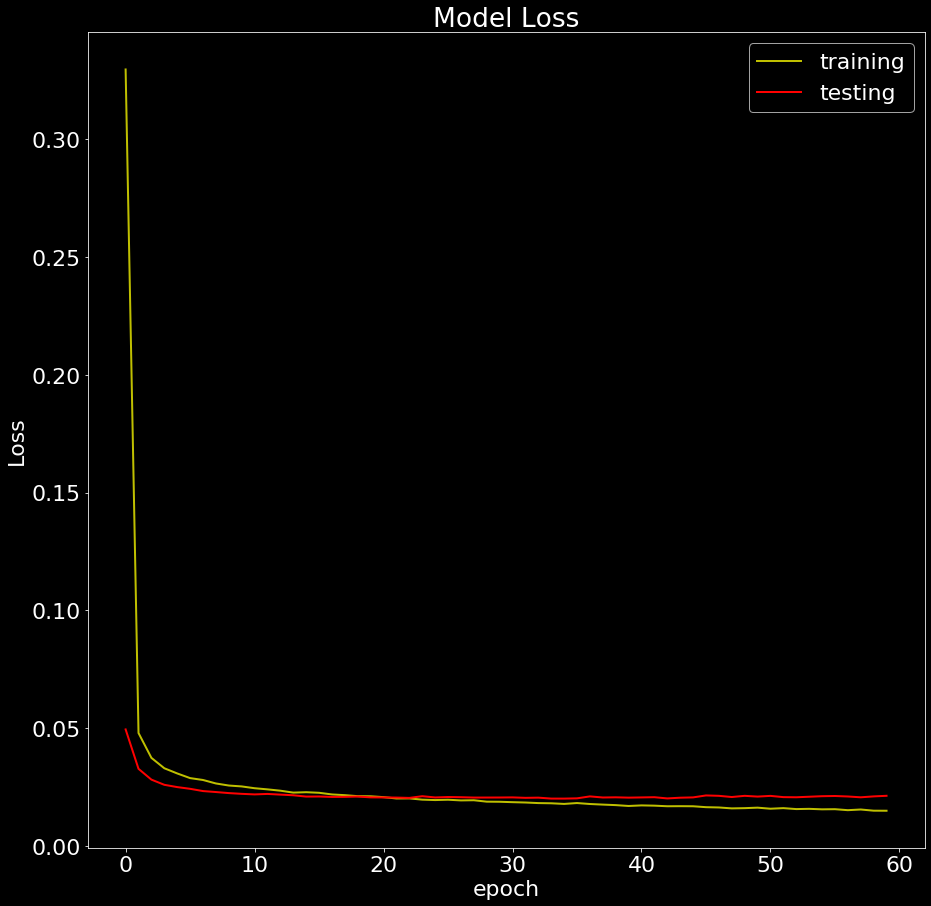

In [27]:
%matplotlib inline
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = [15, 15]
plt.style.use(['dark_background'])
plt.plot(history.history['loss'], c='y',linewidth=2.0)
plt.plot(history.history['val_loss'], c='r',linewidth=2.0)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training','testing'])

In [28]:
plt.show()

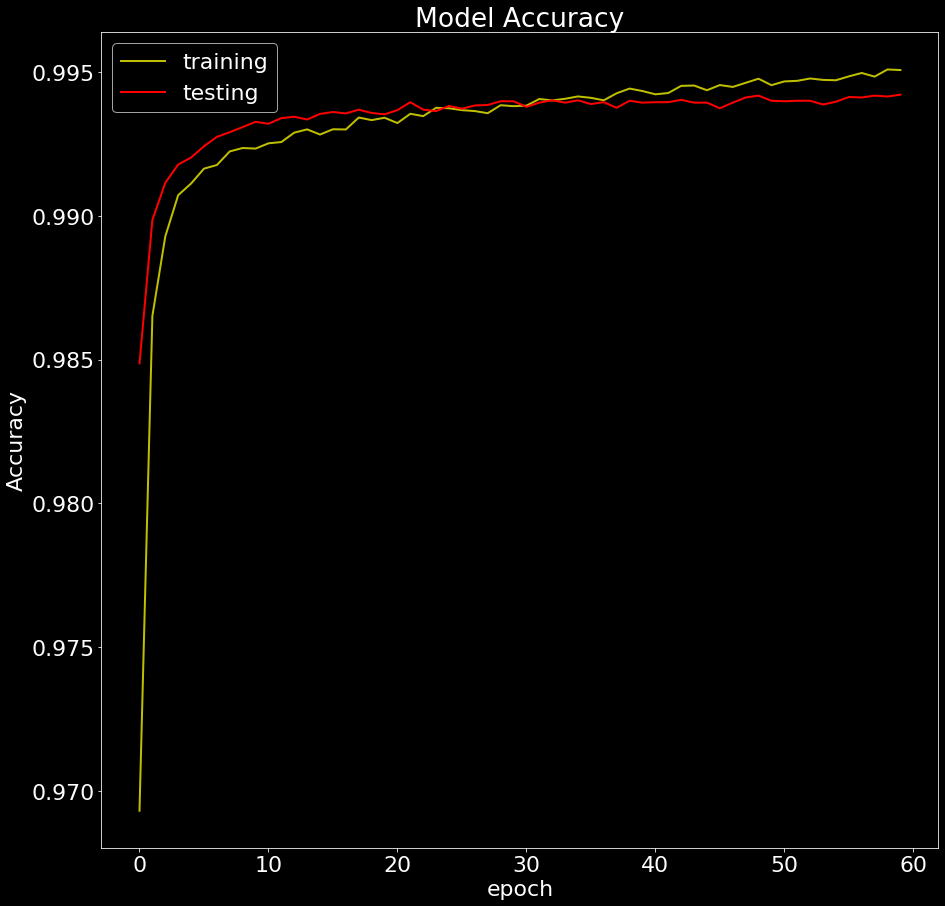

In [30]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = [15, 15]
#plt.style.use(['dark_background'])
plt.plot(history.history['accuracy'], c='y',linewidth=2.0)
plt.plot(history.history['val_accuracy'], c='r',linewidth=2.0)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['training','testing'])

In [31]:
plt.show()

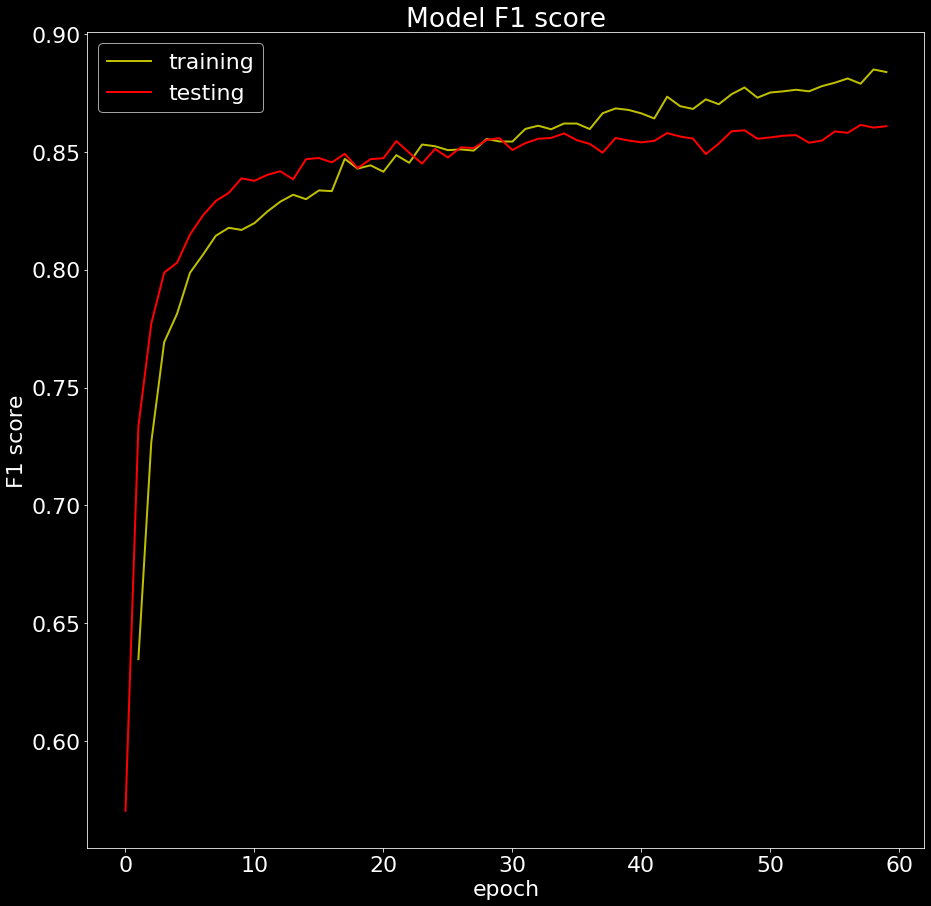

In [32]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = [15, 15]
#plt.style.use(['dark_background'])
plt.plot(history.history['f1'], c='y',linewidth=2.0)
plt.plot(history.history['val_f1'], c='r',linewidth=2.0)
plt.title('Model F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['training','testing'])

In [34]:
plt.show()

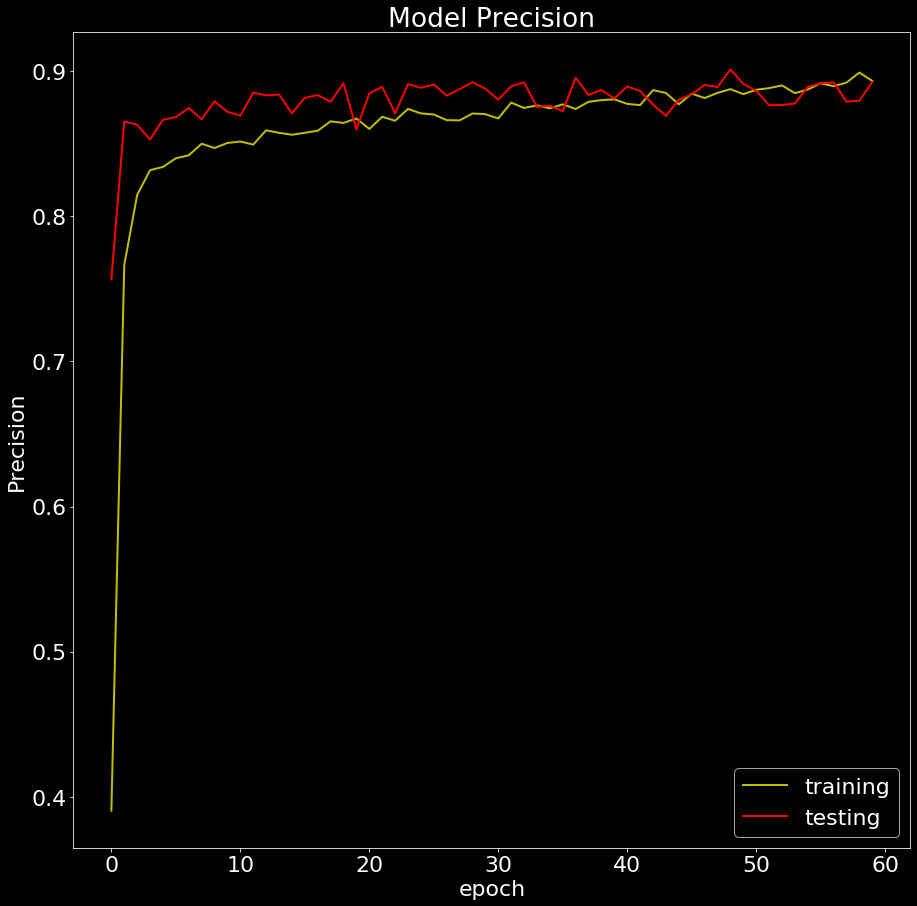

In [33]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = [15, 15]
#plt.style.use(['dark_background'])
plt.plot(history.history['precision'], c='y',linewidth=2.0)
plt.plot(history.history['val_precision'], c='r',linewidth=2.0)
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['training','testing'])

In [34]:
plt.show()

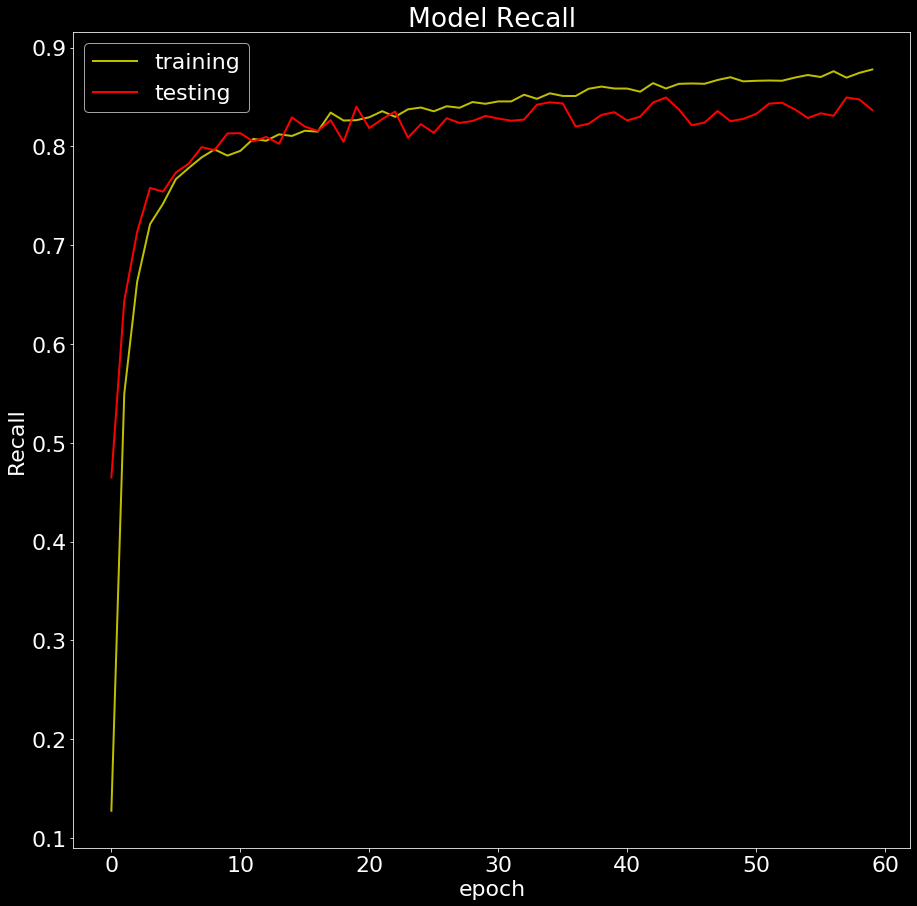

In [35]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = [15, 15]
#plt.style.use(['dark_background'])
plt.plot(history.history['recall'], c='y',linewidth=2.0)
plt.plot(history.history['val_recall'], c='r',linewidth=2.0)
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['training','testing'])

In [38]:
plt.show()

In [37]:
lhistory = lstm_model.fit(X, Y, validation_split=0.20, epochs = 60)

Train on 4088 samples, validate on 1022 samples
Epoch 1/60
4088/4088 [==============================] - 35s 9ms/step - loss: 0.0596 - f1: nan - precision: 0.5170 - recall: 0.2017 - accuracy: 0.9803 - val_loss: 0.0378 - val_f1: 0.5930 - val_precision: 0.8373 - val_recall: 0.4684 - val_accuracy: 0.9863
Epoch 2/60
4088/4088 [==============================] - 36s 9ms/step - loss: 0.0365 - f1: 0.6639 - precision: 0.7444 - recall: 0.6077 - accuracy: 0.9868 - val_loss: 0.0256 - val_f1: 0.8020 - val_precision: 0.8447 - val_recall: 0.7692 - val_accuracy: 0.9918
Epoch 3/60
4088/4088 [==============================] - 36s 9ms/step - loss: 0.0305 - f1: 0.7464 - precision: 0.7841 - recall: 0.7199 - accuracy: 0.9894 - val_loss: 0.0242 - val_f1: 0.8142 - val_precision: 0.8460 - val_recall: 0.7896 - val_accuracy: 0.9922
Epoch 4/60
4088/4088 [==============================] - 36s 9ms/step - loss: 0.0281 - f1: 0.7689 - precision: 0.7949 - recall: 0.7499 - accuracy: 0.9902 - val_loss: 0.0231 - val_f1: 0.

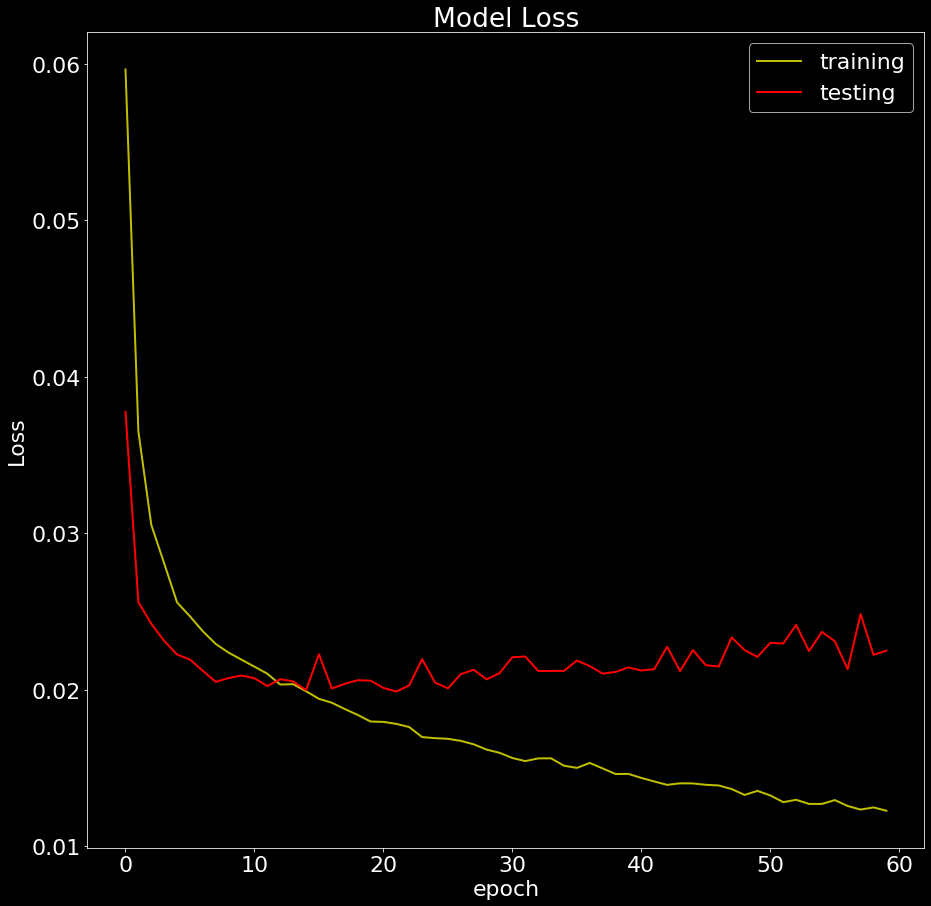

In [38]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = [15, 15]
#plt.style.use(['dark_background'])
plt.plot(lhistory.history['loss'], c='y',linewidth=2.0)
plt.plot(lhistory.history['val_loss'], c='r',linewidth=2.0)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training','testing'])

In [39]:
plt.show()

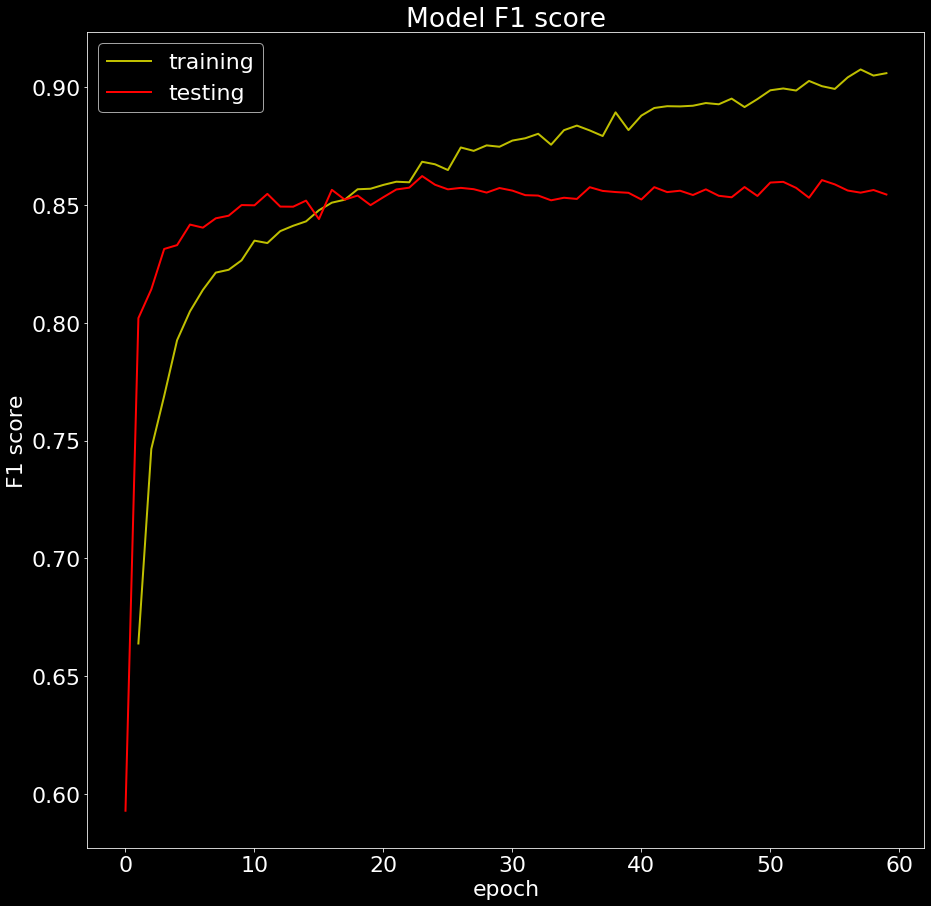

In [40]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = [15, 15]
#plt.style.use(['dark_background'])
plt.plot(lhistory.history['f1'], c='y',linewidth=2.0)
plt.plot(lhistory.history['val_f1'], c='r',linewidth=2.0)
plt.title('Model F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['training','testing'])

In [41]:
plt.show()

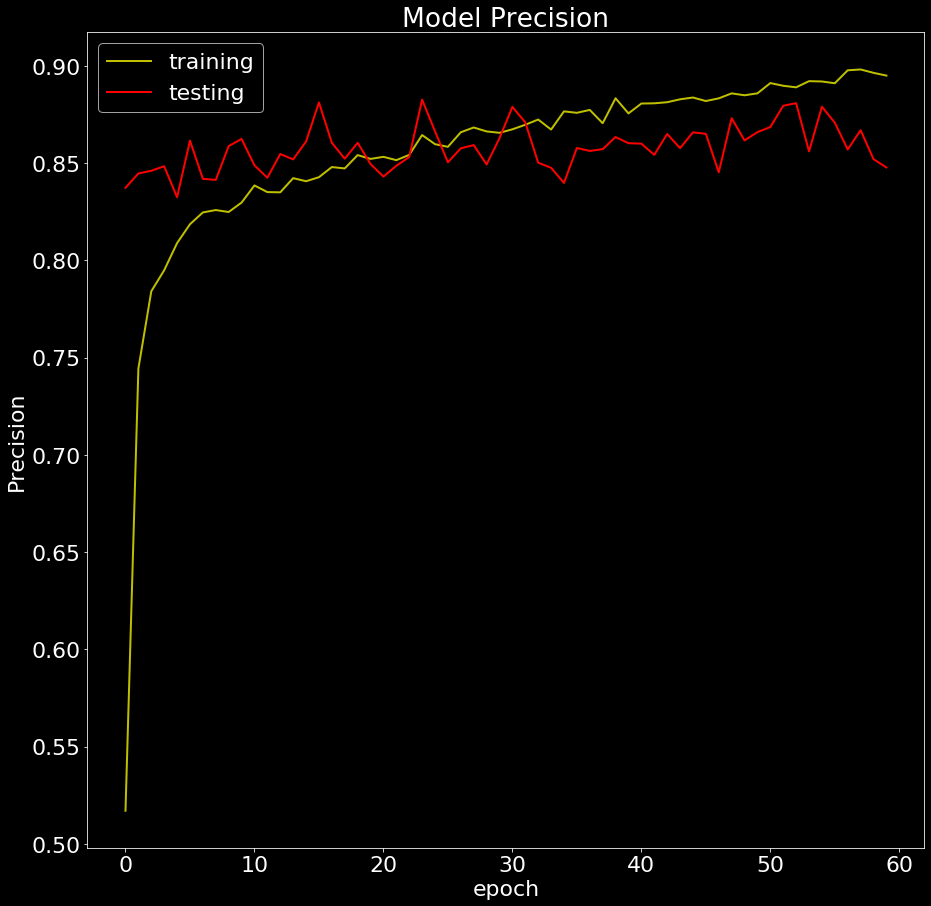

In [42]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = [15, 15]
#plt.style.use(['dark_background'])
plt.plot(lhistory.history['precision'], c='y',linewidth=2.0)
plt.plot(lhistory.history['val_precision'], c='r',linewidth=2.0)
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['training','testing'])

In [43]:
plt.show()

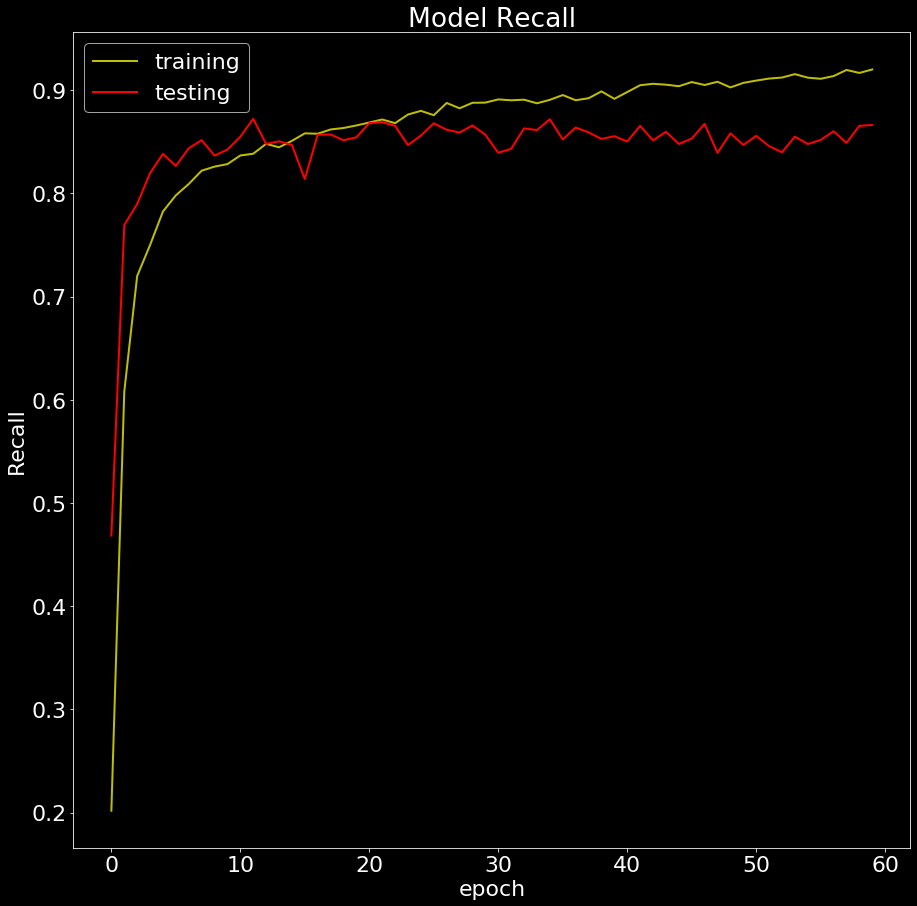

In [44]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = [15, 15]
#plt.style.use(['dark_background'])
plt.plot(lhistory.history['recall'], c='y',linewidth=2.0)
plt.plot(lhistory.history['val_recall'], c='r',linewidth=2.0)
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['training','testing'])

In [45]:
plt.show()

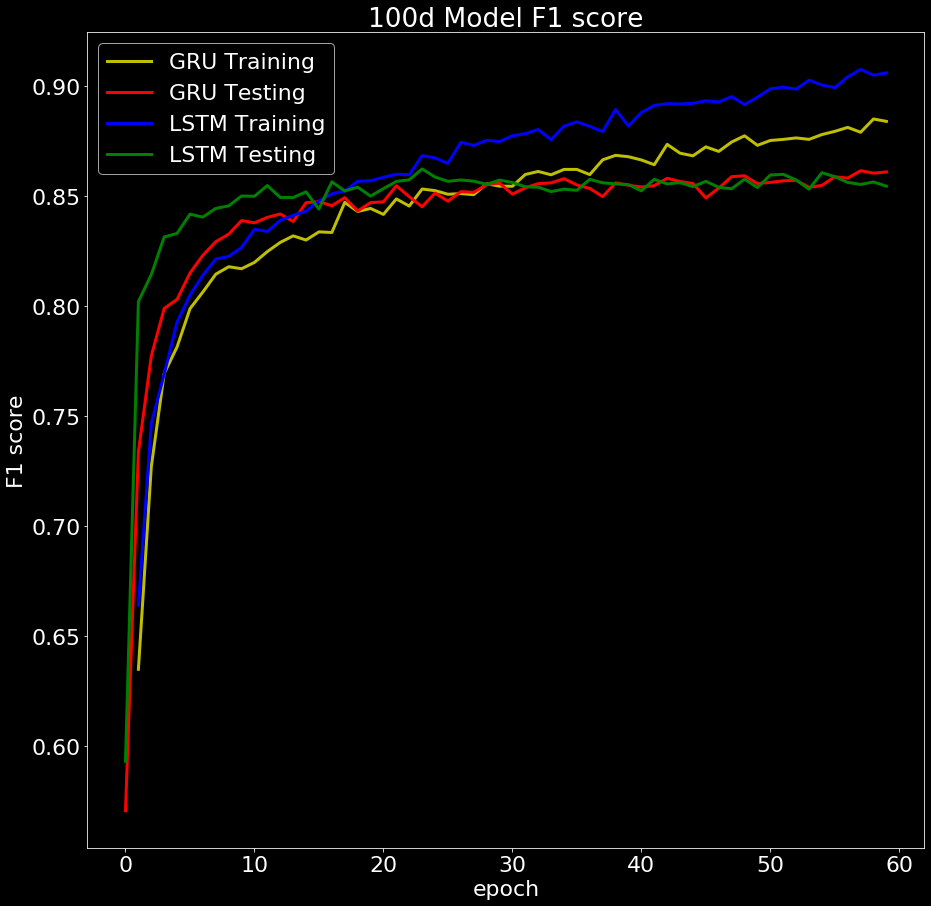

In [46]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = [15, 15]
#plt.style.use(['dark_background'])
plt.plot(history.history['f1'], c='y',linewidth=3)
plt.plot(history.history['val_f1'], c='r',linewidth=3)
plt.plot(lhistory.history['f1'], c='blue', linewidth=3)
plt.plot(lhistory.history['val_f1'], c = 'g', linewidth = 3)
plt.title('100d Model F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['GRU Training','GRU Testing','LSTM Training','LSTM Testing'])

In [ ]:
plt.show()

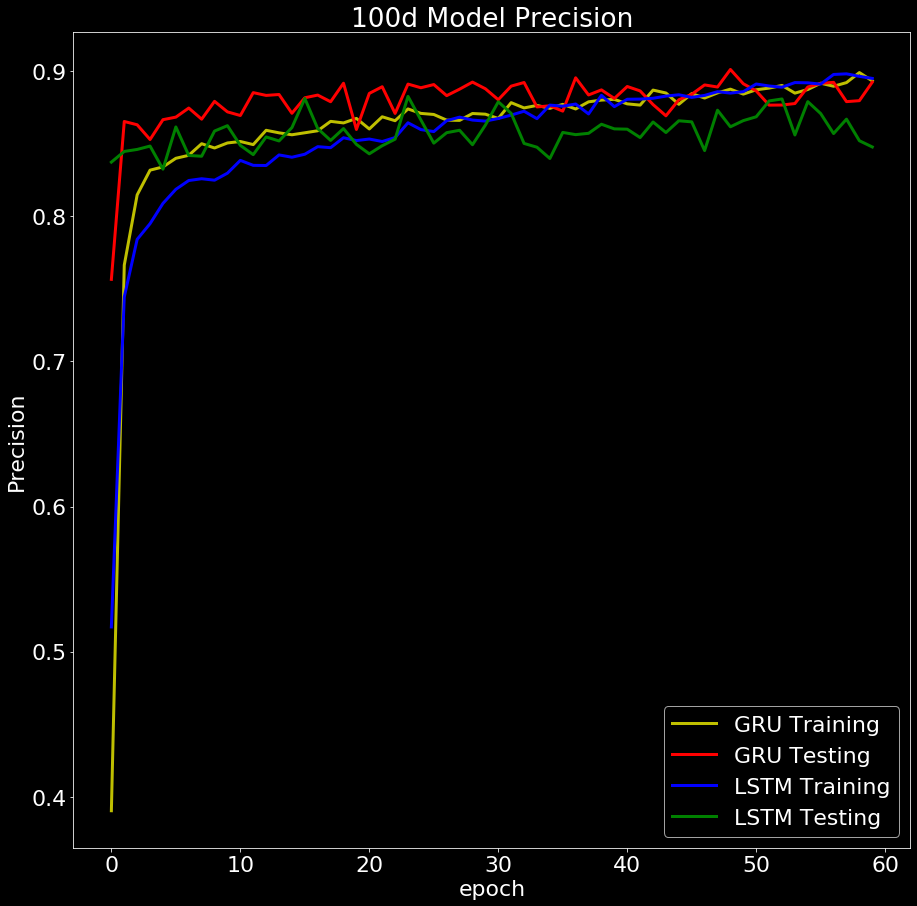

In [47]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = [15, 15]
#plt.style.use(['dark_background'])
plt.plot(history.history['precision'], c='y',linewidth=3)
plt.plot(history.history['val_precision'], c='r',linewidth=3)
plt.plot(lhistory.history['precision'], c='b', linewidth=3)
plt.plot(lhistory.history['val_precision'], c = 'g', linewidth = 3)
plt.title('100d Model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['GRU Training','GRU Testing','LSTM Training','LSTM Testing'])

In [ ]:
plt.show()

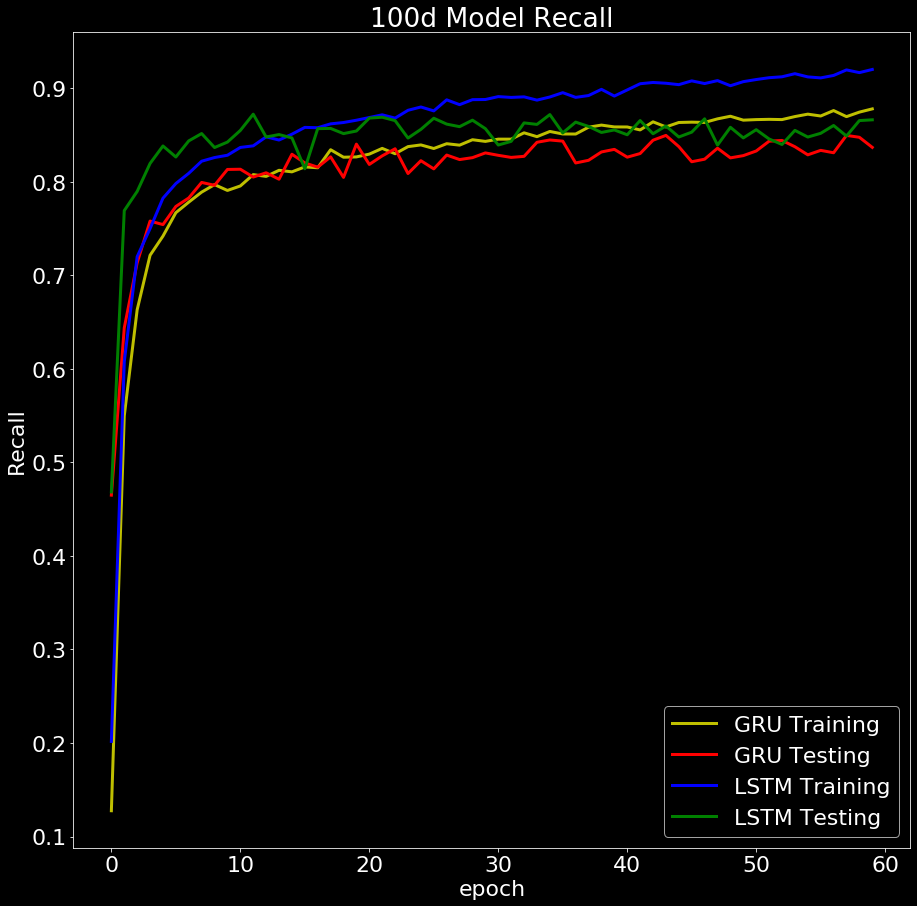

In [48]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = [15, 15]
#plt.style.use(['dark_background'])
plt.plot(history.history['recall'], c='y',linewidth=3)
plt.plot(history.history['val_recall'], c='r',linewidth=3)
plt.plot(lhistory.history['recall'], c='b', linewidth=3)
plt.plot(lhistory.history['val_recall'], c = 'g', linewidth = 3)
plt.title('100d Model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['GRU Training','GRU Testing','LSTM Training','LSTM Testing'])

In [ ]:
plt.show()

In [49]:
[los, fval, pval, rval, acc] = model.evaluate(X, Y)
print('loss: ', los, ' f1: ', fval,' precision: ',pval, ' recall: ', rval, ' accuracy: ', acc)

5110/5110 [==============================] - 3s 618us/step
loss:  0.013373066665724999  f1:  0.8985563516616821  precision:  0.9131748080253601  recall:  0.8907486200332642  accuracy:  0.995746910572052


In [61]:
test_sen = np.array(['today is the eighth anniversary of a catastrophic earthquake that hit haiti and killed over people the resilience of the people of haiti is astonishing'])
t_ind = s2i(test_sen, word_to_index, max_len=25)
op = (model.predict(t_ind)>0.5)
i = 0
t_sn = np.array(test_sen[0].split(' '))
print(set(t_sn[op.flatten()]))
for word in test_sen[0].split(' '):
    print(word,':',op[0][i])
    i+=1

{'haiti'}
today : [False]
is : [False]
the : [False]
eighth : [False]
anniversary : [False]
of : [False]
a : [False]
catastrophic : [False]
earthquake : [False]
that : [False]
hit : [False]
haiti : [ True]
and : [False]
killed : [False]
over : [False]
people : [False]
the : [False]
resilience : [False]
of : [False]
the : [False]
people : [False]
of : [False]
haiti : [ True]
is : [False]
astonishing : [False]


In [63]:
test_sen = np.array(['rt earthquake mb southern xinjiang china'])
t_ind = s2i(test_sen, word_to_index, max_len=10)
op = (model.predict(t_ind)>0.5)
t_sn = np.array(test_sen[0].split(' '))
print(set(t_sn[op.flatten()[:len(t_sn)]]))
i = 0
for word in test_sen[0].split(' '):
    print(word,':',op[0][i])
    i+=1

{'china', 'xinjiang'}
rt : [False]
earthquake : [False]
mb : [False]
southern : [False]
xinjiang : [ True]
china : [ True]


In [64]:
test_sen = np.array(['delete m california baja california border region f'])
t_ind = s2i(test_sen, word_to_index, max_len=10)
op = (model.predict(t_ind)>0.5)
i = 0
t_sn = np.array(test_sen[0].split(' '))
print(set(t_sn[op.flatten()[:len(t_sn)]]))
for word in test_sen[0].split(' '):
    print(word,':',op[0][i])
    i+=1

{'california', 'baja', 'border'}
delete : [False]
m : [False]
california : [ True]
baja : [ True]
california : [ True]
border : [ True]
region : [False]
f : [False]


In [65]:
test_sen = np.array(['rt breaking magnitude earthquake hits southwest of puquio peru at depth of km on sunday according to usgs https'])
t_ind = s2i(test_sen, word_to_index, max_len=60)
op = (model.predict(t_ind)>0.5)
i = 0
t_sn = np.array(test_sen[0].split(' '))
print(set(t_sn[op.flatten()[:len(t_sn)]]))
for word in test_sen[0].split(' '):
    print(word,':',op[0][i])
    i+=1

{'peru', 'puquio'}
rt : [False]
breaking : [False]
magnitude : [False]
earthquake : [False]
hits : [False]
southwest : [False]
of : [False]
puquio : [ True]
peru : [ True]
at : [False]
depth : [False]
of : [False]
km : [False]
on : [False]
sunday : [False]
according : [False]
to : [False]
usgs : [False]
https : [False]


In [66]:
test_sen = np.array(['but who cares because is talking about trump and the dossier who carers that puerto rico jamaica and central america may be in the path of a tsunami as a result of a earthquake sarcasm trash'])
t_ind = s2i(test_sen, word_to_index, max_len=60)
op = (model.predict(t_ind)>0.5)
i = 0
t_sn = np.array(test_sen[0].split(' '))
print(set(t_sn[op.flatten()[:len(t_sn)]]))
for word in test_sen[0].split(' '):
    print(word,':',op[0][i])
    i+=1

{'jamaica', 'rico', 'america'}
but : [False]
who : [False]
cares : [False]
because : [False]
is : [False]
talking : [False]
about : [False]
trump : [False]
and : [False]
the : [False]
dossier : [False]
who : [False]
carers : [False]
that : [False]
puerto : [False]
rico : [ True]
jamaica : [ True]
and : [False]
central : [False]
america : [ True]
may : [False]
be : [False]
in : [False]
the : [False]
path : [False]
of : [False]
a : [False]
tsunami : [False]
as : [False]
a : [False]
result : [False]
of : [False]
a : [False]
earthquake : [False]
sarcasm : [False]
trash : [False]


In [67]:
test_sen = np.array(['rt south reno earthquake swarm over quakes and counting'])
t_ind = s2i(test_sen, word_to_index, max_len=10)
op = (lstm_model.predict(t_ind)>0.5)
i = 0
t_sn = np.array(test_sen[0].split(' '))
print(set(t_sn[op.flatten()[:len(t_sn)]]))
for word in test_sen[0].split(' '):
    print(word,':',op[0][i])
    i+=1

{'reno', 'south'}
rt : [False]
south : [ True]
reno : [ True]
earthquake : [False]
swarm : [False]
over : [False]
quakes : [False]
and : [False]
counting : [False]


In [68]:
test_sen = np.array(['rt earthquake off coast of central america'])
t_ind = s2i(test_sen, word_to_index, max_len=60)
op = (lstm_model.predict(t_ind)>0.5)
i = 0
t_sn = np.array(test_sen[0].split(' '))
print(set(t_sn[op.flatten()[:len(t_sn)]]))
for word in test_sen[0].split(' '):
    print(word,':',op[0][i])
    i+=1

{'america', 'coast'}
rt : [False]
earthquake : [False]
off : [False]
coast : [ True]
of : [False]
central : [False]
america : [ True]


In [69]:
test_sen = np.array(['moderate earthquake mag km ssw of sigave wallis and futuna earthquake quake'])
t_ind = s2i(test_sen, word_to_index, max_len=60)
op = (lstm_model.predict(t_ind)>0.5)
i = 0
t_sn = np.array(test_sen[0].split(' '))
print(set(t_sn[op.flatten()[:len(t_sn)]]))
for word in test_sen[0].split(' '):
    print(word,':',op[0][i])
    i+=1

{'wallis', 'futuna', 'sigave'}
moderate : [False]
earthquake : [False]
mag : [False]
km : [False]
ssw : [False]
of : [False]
sigave : [ True]
wallis : [ True]
and : [False]
futuna : [ True]
earthquake : [False]
quake : [False]


In [70]:
test_sen = np.array(['earthquake in heilongjiang china iphone users download the earthquake app for more information'])
t_ind = s2i(test_sen, word_to_index, max_len=13)
op = (lstm_model.predict(t_ind)>0.5)
i = 0
t_sn = np.array(test_sen[0].split(' '))
print(set(t_sn[op.flatten()[:len(t_sn)]]))
for word in test_sen[0].split(' '):
    print(word,':',op[0][i])
    i+=1

{'china', 'heilongjiang'}
earthquake : [False]
in : [False]
heilongjiang : [ True]
china : [ True]
iphone : [False]
users : [False]
download : [False]
the : [False]
earthquake : [False]
app : [False]
for : [False]
more : [False]
information : [False]
